# Analysis of Nea. ancestry

In [1]:
setwd("../../slim-neanderthal/notebooks/")

In [2]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [3]:
load_samples <- function () 
{
    suppressMessages({
        sgdp <- load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>% 
            select(-Country, pop = Region) %>% mutate(age = 0, name = fix_name(name)) %>% 
            group_by(name, age, pop) %>% summarise(Latitude = mean(Latitude), 
            Longitude = mean(Longitude)) %>% ungroup
        emhs <- read_delim("../clean_data/emh_ages.txt", delim = " ", 
            col_names = c("name", "age")) %>% mutate(pop = "EMH", 
            Latitude = NA, Longitude = NA) %>% filter(name != 
            "Oase1")
    })
    samples <- bind_rows(emhs, sgdp) %>% select(-Latitude, -Longitude)
    samples
}

In [4]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [5]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [6]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

## Nea ancestry proportion in Africans

In [7]:
inner_join(samples, direct_nea) %>% filter(pop == "Africa") %>% arrange(desc(alpha)) %>%
mutate(name=factor(name, levels=name[order(alpha)])) %>% arrange(alpha) %>% head

Joining, by = "name"


name,age,pop,alpha,method
Yoruba,0,Africa,0.002675305,direct
Esan,0,Africa,0.002746654,direct
Mandenka,0,Africa,0.003181596,direct
Gambian,0,Africa,0.003387230,direct
Dinka,0,Africa,0.003548254,direct
Luo,0,Africa,0.003728236,direct


Joining, by = "name"


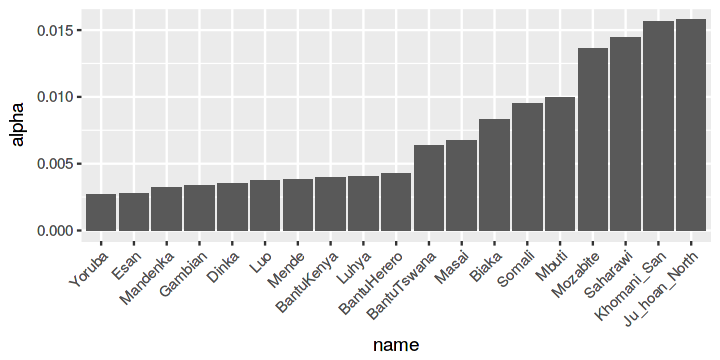

In [8]:
options(repr.plot.width=6, repr.plot.height=3)

inner_join(samples, direct_nea) %>% filter(pop == "Africa") %>% arrange(desc(alpha)) %>%
mutate(name=factor(name, levels=name[order(alpha)])) %>% 
ggplot(aes(name, alpha)) + geom_bar(stat="identity") + theme(axis.text.x=element_text(angle=45, hjust=1))

In [9]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [12]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT_OLD <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den")
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_bigYRI")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_bigYRI.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_bigYRI.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_bigYRI.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all_den_bigYRI.transitions.snp")

In [11]:
subset_sites(prefix=EIGENSTRAT_OLD, out_prefix=EIGENSTRAT, bed_file="../../nea-over-time/data/bed/big_yoruba_array.bed")

### Calculate the number of SNPs available for each sample on the 2.2M array

In [13]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

### Generate a table of SNPs to filter out (transitions)

In [14]:
read_fwf(SNP_FILE,
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_character(),
  gen = col_character(),
  pos = col_character(),
  alt = col_character(),
  ref = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1039548 parsing failures.
row # A tibble: 5 x 5 col     row   col  expected    actual expected   <int> <chr>     <chr>     <chr> actual 1     1   gen  16 chars         4 file 2     1  <NA> 6 columns 3 columns row 3     2   gen  16 chars         4 col 4     2  <NA> 6 columns 3 columns expected 5     3   gen  16 chars         4 actual # ... with 1 more variables: file <chr>
... ................. ... ................................. ........ ................................. ...... ................................. .... ................................. ... ................................. ... ................................. ........ ..........................

In [15]:
dir.create("../admixtools")
setwd("../admixtools")

Warning message in dir.create("../admixtools"):
“'../admixtools' already exists”

<br><br><br><br><br><br><br><br>
# Introduction
## A Tale of <del>Two</del> $N$ Neanderthal estimates, $N \in \{2, ..., \infty\}$


### Neanderthal estimates calculated on the archaic admixture array
![](img/decline_admixture_array.png)

Calculated simply as a proportion of alleles in an individual X that match a Neanderthal allele on biallelic sites at which:

* high-coverage Altai and Vindija genomes are homozygous for one allele,
* YRI population from 1000 GP phase I has a high frequency of the second allele (> 95%).

### Neanderthal estimates based on ratios of f4 statistics
![](img/decline_f4_ice_age.png)

Calculated on a combination of arrays, collectively called the 2.2M sites array:

![](img/2.2Marray.png)

Affymetrix Human Origins Array contains 11 different sets of SNPs, each ascertained on the basis of being heterozygous in a single genome sequence from each of the 11 different populations.

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

![](img/mailund_f4_tree.png)

* A - West and Central Africans
* B - Dinka
* C - new_Altai
* O - Chimp


![](img/ice_age_f4_description.png)

In [17]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Nea=c("new_Altai", "new_Vindija")))

In [18]:
my_iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Nea", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure:

![](img/mailund_f4_tree.png)

* A - new_Altai
* B - Vindija
* C - African
* O - Chimp

In [19]:
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [20]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [21]:
results <- bind_rows(list(my_iceage_Nea,
                          mbuti,
                          yoruba,
                          dinka)) %>% mutate(name=X, method=setup)

In [24]:
table(results$method)


        qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                 151 
        qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                 151 
       qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                 151 
qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp 
                                                 151 

# Plot Nea. estimates over time

So far we have been focusing on evaluating various scenarios of selection that could reproduce the decrease in Neanderthal ancestry that we reported in the Ice Age paper [@fu_genetic_2016]. As a reminder, this is the slope of Neanderthal ancestry form the paper that we are trying to fit:

In [25]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

# combine tables with both estimates into a single table for comparison and merge
# them with counts of SNPs per sample on both admixture array and 2.2M sites arrays
all_nea_estimates <- inner_join(samples, bind_rows(mutate(inner_join(direct_nea, snp_counts_direct), Zscore = Inf),
                                               inner_join(results, snp_counts_f4))) %>%
    select(name, age, pop, alpha, method, snp_count, Zscore) %>% 
    mutate(se=alpha/Zscore)

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"


In [26]:
nea_estimates <- all_nea_estimates %>% 
    filter(pop %in% c("EMH", "WestEurasia"),
                      !name %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                                   "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                      !name %in% non_udg_samples)

In [27]:
nea_estimates %>% filter(name == "UstIshim")

name,age,pop,alpha,method,snp_count,Zscore,se
UstIshim,45020,EMH,0.02810603,direct,157653,Inf,0.000000000
UstIshim,45020,EMH,0.05089000,qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp,518639,7.711,0.006599663
UstIshim,45020,EMH,0.03004200,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,518639,6.187,0.004855665
UstIshim,45020,EMH,0.03841900,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,518639,8.116,0.004733736
UstIshim,45020,EMH,0.02969700,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,518639,6.263,0.004741657


In [28]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * se, ymax=alpha + x * se, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > 3), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) +
        ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) } %>% 
    summary
}

## Results from the Ice Age paper

In [29]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3450599   -94494   517415  1044985  2520498 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -62858      18652  -3.370 0.004578 ** 
.[["alpha"]]  3698914     744043   4.971 0.000205 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1568000 on 14 degrees of freedom
Multiple R-squared:  0.6384,	Adjusted R-squared:  0.6125 
F-statistic: 24.71 on 1 and 14 DF,  p-value: 0.0002051


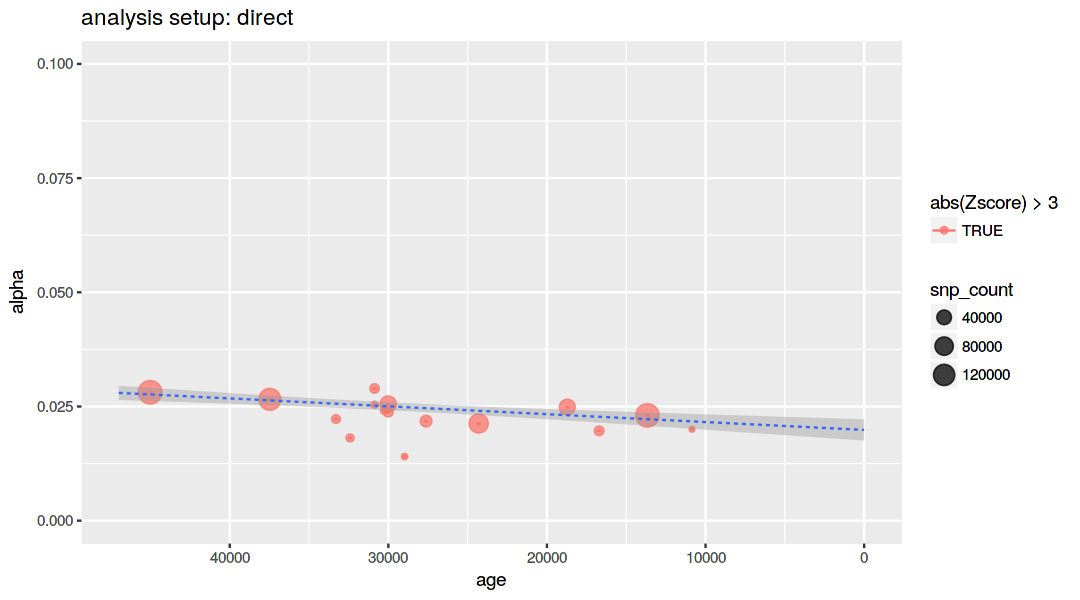

In [30]:
plot_nea_vs_time("direct", youngest=10000)
run_lm("direct", youngest=10000)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-3517853  -804448   334705  1360361  4608142 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -65796       6071  -10.84 3.93e-14 ***
.[["alpha"]]  3529865     315574   11.19 1.39e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2009000 on 45 degrees of freedom
Multiple R-squared:  0.7355,	Adjusted R-squared:  0.7296 
F-statistic: 125.1 on 1 and 45 DF,  p-value: 1.386e-14


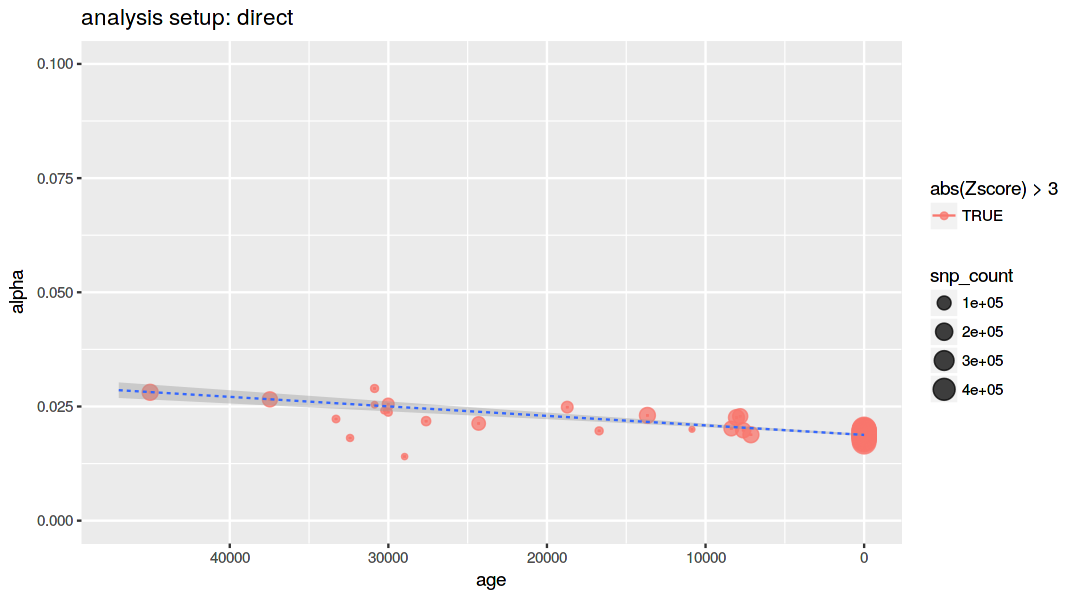

In [31]:
plot_nea_vs_time("direct")
run_lm("direct")

<font color="red">Note that we are actually showing 95% CI instead of just std errors, which are pretty meaningless by themselves (and are actually misleading, because they are small).</font>

Warning message:
“Removed 18 rows containing missing values (geom_point).”Warning message:
“Removed 31 rows containing missing values (geom_errorbar).”

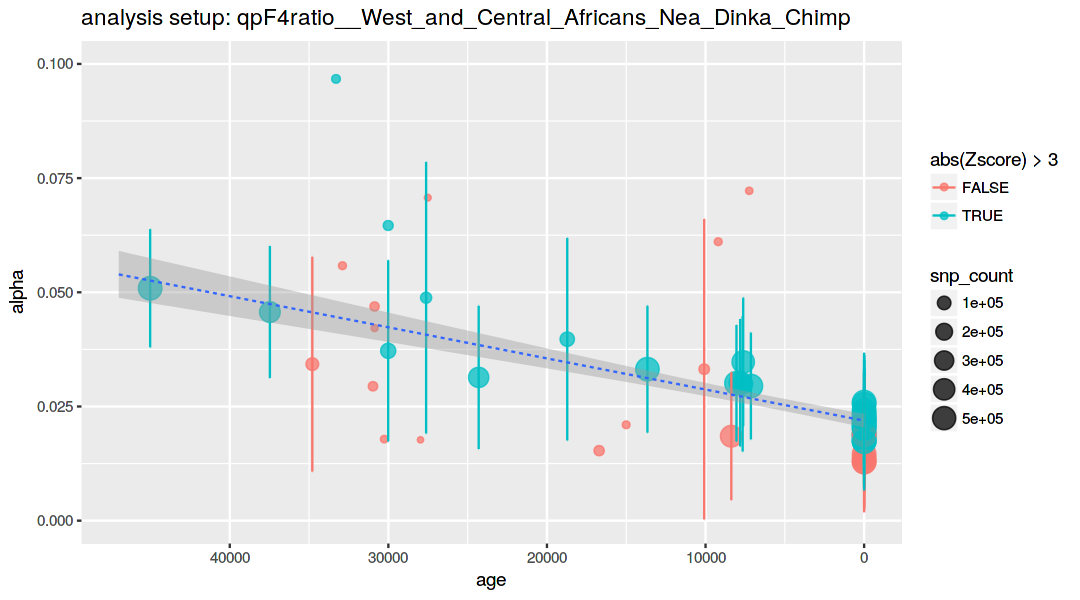

In [32]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp", ylim=c(0, 0.1))

# New f4 results

In [33]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-5698606 -2636287   114634  3009933 26085602 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)    -10403       6221  -1.672   0.0989 .
.[["alpha"]]   639155     255881   2.498   0.0148 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5164000 on 70 degrees of freedom
Multiple R-squared:  0.08184,	Adjusted R-squared:  0.06872 
F-statistic: 6.239 on 1 and 70 DF,  p-value: 0.01485


Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 32 rows containing missing values (geom_errorbar).”

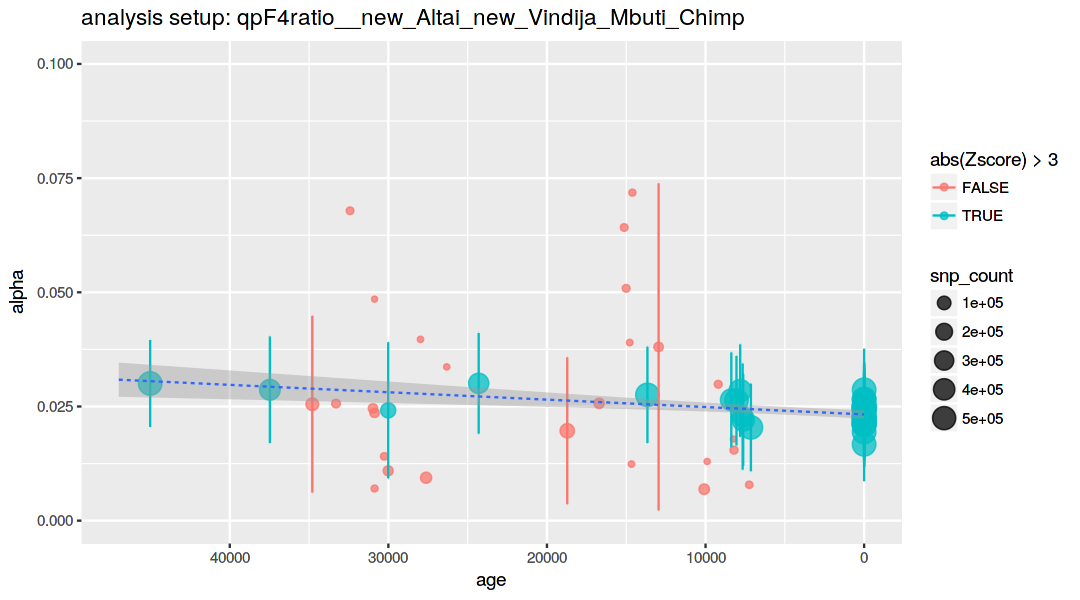

In [38]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-5546759 -2610304    19762  2844794 26288860 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)     -9179       6075  -1.511   0.1353  
.[["alpha"]]   595847     253010   2.355   0.0213 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5188000 on 70 degrees of freedom
Multiple R-squared:  0.07341,	Adjusted R-squared:  0.06018 
F-statistic: 5.546 on 1 and 70 DF,  p-value: 0.02133


Warning message:
“Removed 8 rows containing missing values (geom_point).”Warning message:
“Removed 32 rows containing missing values (geom_errorbar).”

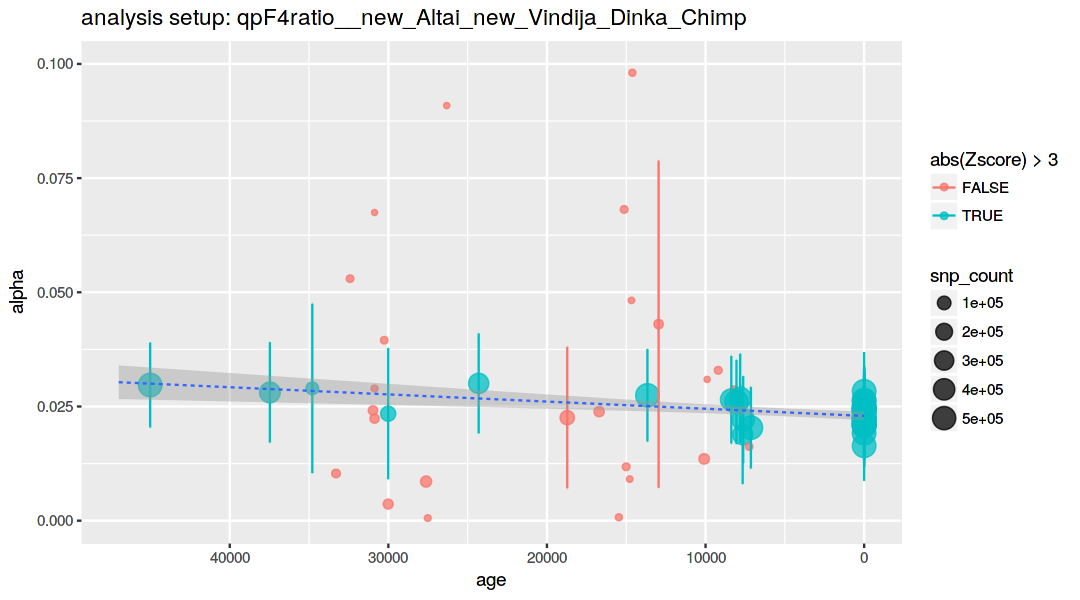

In [39]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-4865472 -2959675   507227  2589694 27133227 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -7784       7799  -0.998    0.322
.[["alpha"]]   393758     240145   1.640    0.106

Residual standard error: 5289000 on 70 degrees of freedom
Multiple R-squared:  0.03699,	Adjusted R-squared:  0.02323 
F-statistic: 2.689 on 1 and 70 DF,  p-value: 0.1056


Warning message:
“Removed 10 rows containing missing values (geom_point).”Warning message:
“Removed 31 rows containing missing values (geom_errorbar).”

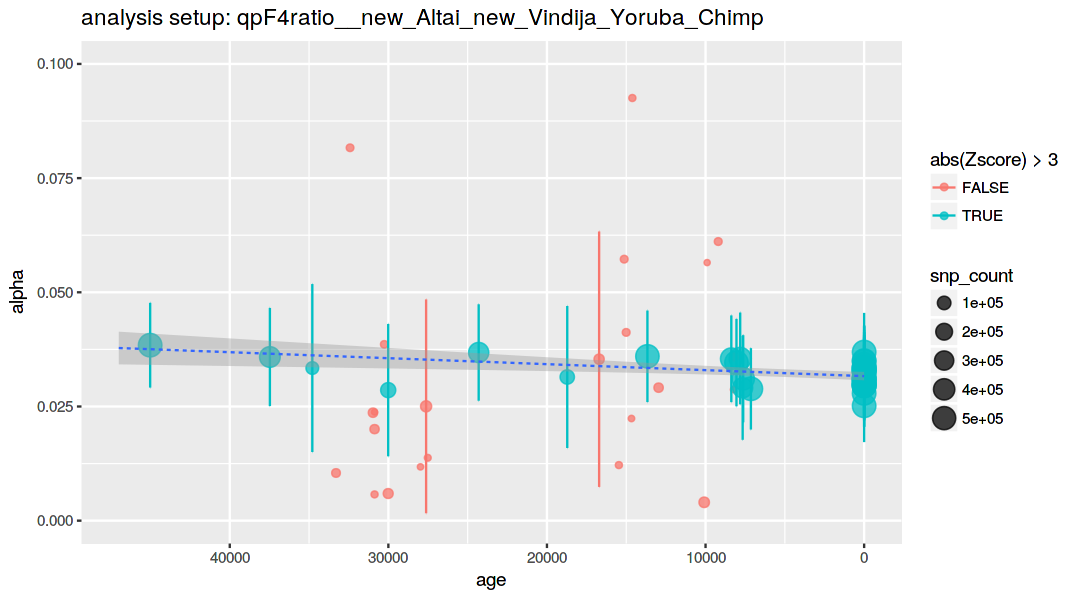

In [40]:
run_lm("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")

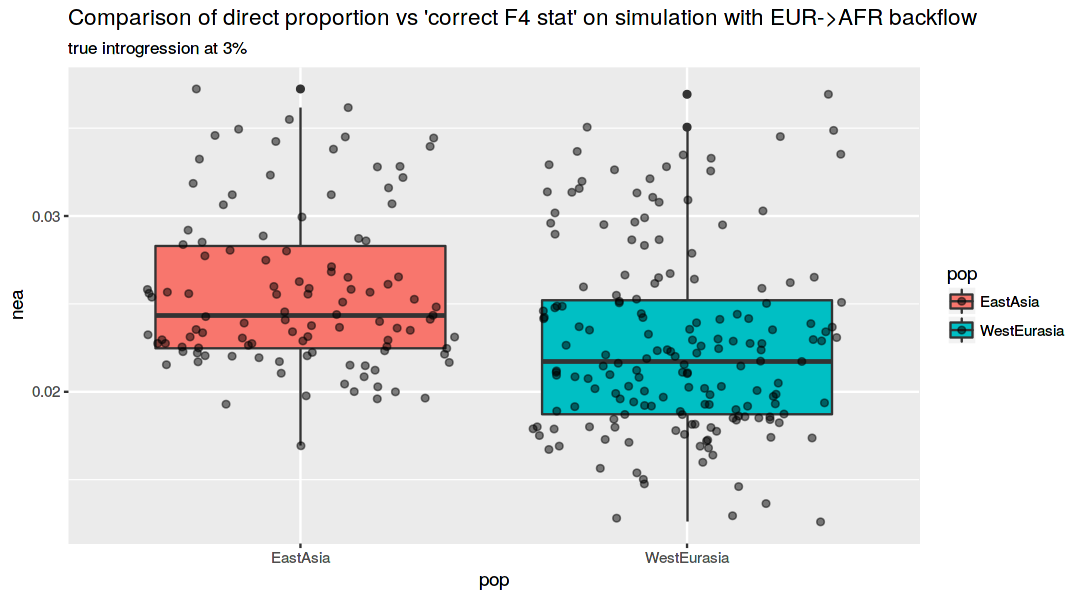

In [42]:
filter(all_nea_estimates, pop %in% c("WestEurasia", "EastAsia")) %>% select(pop, nea=alpha) %>%
    gather(pop, nea) %>%
    ggplot(aes(pop, nea, fill=pop)) + geom_boxplot() + geom_jitter(alpha=1/2) +
    ggtitle("Comparison of direct proportion vs 'correct F4 stat' on simulation with EUR->AFR backflow",
            "true introgression at 3%")